<a href="https://colab.research.google.com/github/elfkr7/Intro-to-DL/blob/main/Perceptron_HW1_Elif_KIR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem 8 is at the bottom.

In [ ]:
#Import the Data
#!/usr/bin/env python3

import urllib.request
import tarfile


url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
fileobj = urllib.request.urlopen(url)

print('Downloading...')
with tarfile.open(fileobj=fileobj, mode="r|gz") as tar:
    tar.extractall()

Downloading...


In [ ]:
"""Data preprocessing."""

import os
import pickle
from typing import Any, Tuple

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


def load_pickle(f: str) -> Any:
    """Load a pickle file.

    Parameters:
        f: the pickle filename

    Returns:
        the pickled data
    """
    return pickle.load(f, encoding="latin1")


def load_CIFAR_batch(filename: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Load a single batch of cifar data.

    Parameters:
        filename: the pickle filename

    Returns:
        the data
        the labels
    """
    with open(filename, "rb") as f:
        datadict = load_pickle(f)
        X = datadict["data"]
        Y = datadict["labels"]
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float")
        Y = np.array(Y)
        return X, Y


def load_CIFAR10(ROOT: str) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Load all of cifar data.

    Parameters:
        ROOT: the root directory containing the data

    Returns:
        training data
        training labels
        testing data
        testing labels
    """
    xs = []
    ys = []
    for b in range(1, 6):
        f = os.path.join(ROOT, "data_batch_{}".format(b))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, "test_batch"))
    return Xtr, Ytr, Xte, Yte


def get_CIFAR10_data(
    num_training: int = 49000,
    num_validation: int = 1000,
    num_test: int = 10000,
    subtract_mean: bool = True,
):
    """Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for classifiers. These are the same steps as we used for the SVM, but
    condensed to a single function.

    Parameters:
        num_training: number of training images
        num_validation: number of validation images
        num_test: number of test images
        subtract_mean: whether or not to normalize the data

    Returns:
        the train/val/test data and labels
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = os.path.join("cifar-10-batches-py")
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    if subtract_mean:
        mean_image = np.mean(X_train, axis=0)
        X_train -= mean_image
        X_val -= mean_image
        X_test -= mean_image

    # Transpose so that channels come first
    X_train = X_train.transpose(0, 3, 1, 2).copy()
    X_val = X_val.transpose(0, 3, 1, 2).copy()
    X_test = X_test.transpose(0, 3, 1, 2).copy()

    # Package data into a dictionary
    return {
        "X_train": X_train,
        "y_train": y_train,
        "X_val": X_val,
        "y_val": y_val,
        "X_test": X_test,
        "y_test": y_test,
    }



In [ ]:
"""Utility functions for saving predictions for submission."""

import csv

import numpy as np


def write_csv(file_path: str, y_list: np.ndarray):
    """Write a CSV file.

    Parameters:
        file_path: name of the file to save
        y_list: y predictions
    """
    solution_rows = [("id", "category")] + [(i, y) for (i, y) in enumerate(y_list)]
    with open(file_path, "w") as f:
        writer = csv.writer(f)
        writer.writerows(solution_rows)


def output_submission_csv(output_file_path: str, y_test: np.ndarray):
    """Save predictions.

    Parameters:
        output_file_path: name of the file to save
        y_test: y predictions
    """
    write_csv(output_file_path, y_test)


In [ ]:
#libraries
import random
import numpy as np
#from data_process import get_CIFAR10_data
from scipy.spatial import distance
%matplotlib inline
from save_submission import output_submission_csv

In [ ]:
# You can change these numbers for experimentation
# For submission we will use the default values 
TRAIN_IMAGES = 40000
VAL_IMAGES = 10000

In [ ]:
#Split the data
data = get_CIFAR10_data(TRAIN_IMAGES, VAL_IMAGES)
X_train_CIFAR, y_train_CIFAR = data['X_train'], data['y_train']
X_val_CIFAR, y_val_CIFAR = data['X_val'], data['y_val']
X_test_CIFAR, y_test_CIFAR = data['X_test'], data['y_test']
n_class_CIFAR = len(np.unique(y_test_CIFAR))

In [ ]:
#Reshape the data
X_train_CIFAR = np.reshape(X_train_CIFAR, (X_train_CIFAR.shape[0], -1))
X_val_CIFAR = np.reshape(X_val_CIFAR, (X_val_CIFAR.shape[0], -1))
X_test_CIFAR = np.reshape(X_test_CIFAR, (X_test_CIFAR.shape[0], -1))


In [ ]:
#Perceptron
import numpy as np


class Perceptron:
    def __init__(self, n_class: int, lr: float, epochs: int):
        """Initialize a new classifier.
        Parameters:
            n_class: the number of classes
            lr: the learning rate
            epochs: the number of epochs to train for
        """
        self.w = np.random.randn() #np.randn(3073,1) ###### TODO: change this
        self.lr = lr #0.1 ###### TODO: change this
        self.epochs = epochs #10 ###### TODO: change this
        self.n_class = n_class #10 ###### TODO: change this

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        """Train the classifier.
        Use the perceptron update rule as introduced in Lecture 3.
        Parameters:
            X_train: a number array of shape (N, D) containing training data;
                N examples with D dimensions
            y_train: a numpy array of shape (N,) containing training labels
        """
        N, D = X_train.shape
        self.w = np.random.randn(self.n_class, D+1) #+1 for bias term 
        X_train_stacked = np.hstack((np.ones((N,1)),X_train)) #add one more dimension with full of ones

        ###### YOUR CODE STARTS HERE ######
        
        for  epochs in range(self.epochs):
          for p in range(N):
            y_hat= np.dot(self.w,X_train_stacked[p])
            y_predicted = np.argmax(y_hat, axis=0)
            y_= y_train[p]
            if y_!=y_predicted:
              self.w[y_]= self.w[y_] + self.lr*X_train_stacked[p]
              self.w[y_predicted]= self.w[y_predicted] - self.lr*X_train_stacked[p]
          return(self.w)
          
         
        ###### YOUR CODE ENDS HERE ######
        pass

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """Use the trained weights to predict labels for test data points.
        Parameters:
            X_test: a numpy array of shape (N, D) containing testing data;
                N examples with D dimensions
        Returns:
            predicted labels for the data in X_test; a 1-dimensional array of
                length N, where each element is an integer giving the predicted
                class.
        """
        N, D = X_test.shape
        y_test = np.zeros(N)
        ###### YOUR CODE STARTS HERE ######
        X_test_stacked = np.hstack((np.ones((N,1)),X_test)) #add one more dimension with full of ones
        y_hat= np.dot(self.w,X_test_stacked.T)
        y_test = np.argmax(y_hat, axis=0)
        ###### YOUR CODE ENDS HERE ######
        return y_test

In [ ]:
lr = 0.5
n_epochs = 100

percept_CIFAR = Perceptron(n_class_CIFAR, lr, n_epochs)
percept_CIFAR.train(X_train_CIFAR, y_train_CIFAR)

array([[ -137.30911201,  -433.34284684,  -683.15698744, ...,
         -617.08529548,  -571.13941257,  -821.7322969 ],
       [ -215.38847499,    -8.27020756,  -613.25551652, ...,
          527.52254446,    86.35963885,  -704.75568502],
       [  257.99082957,  -419.71854385,   359.00074472, ...,
          158.53983639,  -678.62210951,  -547.72704706],
       ...,
       [  116.57429984,   840.90045583,   477.25999209, ...,
         -988.92182895,  -523.14521413,   217.6397778 ],
       [ -222.15332887,   451.6401134 ,   216.61261532, ...,
          530.21019269,  1273.93712702,  1074.7207764 ],
       [ -178.20027177,  -470.48329638, -1016.11573732, ...,
          379.68067071,   955.42267019,  1524.35104656]])

In [ ]:
#Get accuracy 
def get_acc(pred, y_test):
  return np.sum(y_test==pred)/len(y_test)*100

In [ ]:
pred_percept = percept_CIFAR.predict(X_train_CIFAR)
print('The training accuracy is given by: %f' % (get_acc(pred_percept, y_train_CIFAR)))

The training accuracy is given by: 30.442500


In [ ]:
pred_percept = percept_CIFAR.predict(X_val_CIFAR)
print('The validation accuracy is given by: %f' % (get_acc(pred_percept, y_val_CIFAR)))

The validation accuracy is given by: 28.140000


In [ ]:
pred_percept = percept_CIFAR.predict(X_test_CIFAR)
print('The testing accuracy is given by: %f' % (get_acc(pred_percept, y_test_CIFAR)))

The testing accuracy is given by: 28.160000


In [ ]:
output_submission_csv('Perceptron_submission_CIFAR.csv', percept_CIFAR.predict(X_test_CIFAR))

In [ ]:
#Logistic

"""Logistic regression model."""
from numpy.lib.arraysetops import unique
import numpy as np
import math


class Logistic:
    def __init__(self, lr: float, epochs: int):
        """Initialize a new classifier.
        Parameters:
            lr: the learning rate
            epochs: the number of epochs to train for
        """
        self.w = np.random.randn() ###### TODO: change this
        self.lr = lr  ###### TODO: change this
        self.epochs = epochs ###### TODO: change this
        self.threshold = 0.5 ###### TODO: change this

    def sigmoid(self, z: np.ndarray) -> np.ndarray:
        """Sigmoid function.
        Parameters:
            z: the input
        Returns:
            the sigmoid of the input
        """
        ##### YOUR CODE STARTS HERE #####
        ret= 1/(1 + np.exp(-z))
        
        ##### YOUR CODE ENDS HERE #####
        return ret

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        """Train the classifier.
        Use the logistic regression update rule as introduced in lecture.
        Parameters:
            X_train: a numpy array of shape (N, D) containing training data;
                N examples with D dimensions
            y_train: a numpy array of shape (N,) containing training labels
        """
        N, D = X_train.shape
        self.w = np.random.randn(D+1) #+1 for bias term 
        X_train_stacked = np.hstack((np.ones((N,1)),X_train)) #add one more dimension with full of ones
        

        ##### YOUR CODE STARTS HERE #####
        n_class=len(np.unique(y_train))
        all_w=np.zeros((n_class,D+1))
        for p in range(n_class):
          binary_y=np.array(p==y_train,dtype=int)
          for  epochs in range(self.epochs):
              h=np.dot(self.w,X_train_stacked.T)
              h=((h-min(h))/(max(h)-min(h)))#normalization to aviod infinity in sigmoid for extreme values
              h=self.sigmoid(h)
              grad=np.dot((h-binary_y),X_train_stacked)/N
              self.w-=self.lr*grad
          all_w[p]=self.w.T
        self.w=all_w
        return(self.w)

     
        ##### YOUR CODE ENDS HERE #####
        pass

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """Use the trained weights to predict labels for test data points.
        Parameters:
            X_test: a numpy array of shape (N, D) containing testing data;
                N examples with D dimensions
        Returns:
            predicted labels for the data in X_test; a 1-dimensional array of
                length N, where each element is an integer giving the predicted
                class.
        """
        N, D = X_test.shape
        y_test = np.zeros(N)
        ##### YOUR CODE STARTS HERE #####
        X_test_stacked = np.hstack((np.ones((N,1)),X_test)) #add one more dimension with full of ones
        y_hat= self.sigmoid(np.dot(self.w,X_test_stacked.T))
        y_test = np.argmax(y_hat, axis=0)    
        
        ##### YOUR CODE ENDS HERE #####
        return y_test

In [ ]:
learning_rate = 0.03
n_epochs = 100

lr = Logistic(learning_rate, n_epochs)
lr.train(X_train_CIFAR, y_train_CIFAR)

array([[ -0.7003843 ,  -0.81175956,  -1.87924774, ...,   3.98318311,
          3.53406665,   1.50980446],
       [ -2.2391535 ,  -1.56344586,  -2.56174846, ...,   4.89070317,
          4.6118736 ,   2.69309659],
       [ -3.77273144,  -2.4658642 ,  -3.25664895, ...,   2.5662606 ,
          2.13562823,   0.09125428],
       ...,
       [-11.5309244 ,   0.40119672,  -0.34207332, ...,  -4.14802567,
         -4.7725829 ,  -6.76049326],
       [-13.1000256 ,   2.25779573,   1.45282496, ...,  -4.52532805,
         -4.84065745,  -6.6193168 ],
       [-14.68011719,   8.50334997,   7.59677739, ...,  -1.58052132,
         -1.66952707,  -3.35207266]])

In [ ]:
pred_lr = lr.predict(X_train_CIFAR)
print('The training accuracy is given by: %f' % (get_acc(pred_lr, y_train_CIFAR)))

The training accuracy is given by: 17.522500


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in exp


In [ ]:
pred_lr = lr.predict(X_val_CIFAR)
print('The validation accuracy is given by: %f' % (get_acc(pred_lr, y_val_CIFAR)))

The validation accuracy is given by: 17.570000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in exp


In [ ]:
pred_lr = lr.predict(X_test_CIFAR)
print('The testing accuracy is given by: %f' % (get_acc(pred_lr, y_test_CIFAR)))

lr



The testing accuracy is given by: 17.540000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in exp


In [ ]:
output_submission_csv('Logistic_submission_CIFAR.csv', lr.predict(X_test_CIFAR))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in exp


In [ ]:
arr_epochs=[10,30,50]
Accuracy_train_accumulated = []
Accuracy_test_accumulated = []
for i in range(len(arr_epochs)):
  lr = Logistic(0.1, arr_epochs[i])
  lr.train(X_train_CIFAR, y_train_CIFAR)
  pred_lr = lr.predict(X_test_CIFAR)
  Accuracy_train_accumulated.append(lr.predict(X_train_CIFAR))
  Accuracy_test_accumulated.append(lr.predict(X_test_CIFAR))



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in exp


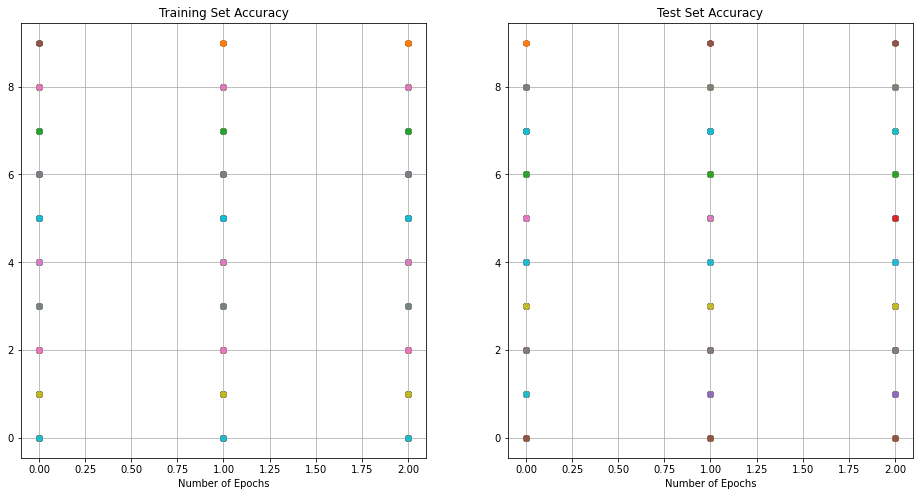

In [ ]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(1,2,figsize=(16, 8))
ax[0].plot(Accuracy_train_accumulated, 'h');
ax[1].plot(Accuracy_test_accumulated, 'h')
ax[0].set(title='Training Set Accuracy', xlabel='Number of Epochs')
ax[1].set(title='Test Set Accuracy',xlabel='Number of Epochs')
ax[0].grid()
ax[1].grid()
plt.show()

In [ ]:
##Problem 8
y=np.array(np.linspace(start= -20, stop= 20, num= 401, axis=0)).reshape(-1,1)
j=np.linspace(start= 1, stop= 50, num= 50, axis=0)
X=y**j
#X[400]
X

array([[-2.00000000e+01,  4.00000000e+02, -8.00000000e+03, ...,
         2.81474977e+62, -5.62949953e+63,  1.12589991e+65],
       [-1.99000000e+01,  3.96010000e+02, -7.88059900e+03, ...,
         2.21282805e+62, -4.40352782e+63,  8.76302035e+64],
       [-1.98000000e+01,  3.92040000e+02, -7.76239200e+03, ...,
         1.73751728e+62, -3.44028422e+63,  6.81176275e+64],
       ...,
       [ 1.98000000e+01,  3.92040000e+02,  7.76239200e+03, ...,
         1.73751728e+62,  3.44028422e+63,  6.81176275e+64],
       [ 1.99000000e+01,  3.96010000e+02,  7.88059900e+03, ...,
         2.21282805e+62,  4.40352782e+63,  8.76302035e+64],
       [ 2.00000000e+01,  4.00000000e+02,  8.00000000e+03, ...,
         2.81474977e+62,  5.62949953e+63,  1.12589991e+65]])